In [1]:
import time
import os
import random
import numpy as np                                                
import matplotlib.pyplot as plt                                   
import autograd, autograd.core, autograd.extend, autograd.tracer  
import autograd.numpy as anp      
import scipy, scipy.ndimage, scipy.sparse, scipy.sparse.linalg    
                                                     
import gym
import gymnasium
from gymnasium import spaces


from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter

In [2]:
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor, VecEnv

In [3]:
from stable_baselines3.common.vec_env.base_vec_env import VecEnv, VecEnvStepReturn, VecEnvWrapper

In [4]:
from stable_baselines3.common.vec_env import SubprocVecEnv

Aim of the moddeling:

- if you want to train multiple envs at once e.g. to do multiple abstraction levels design between: comprehensive levels as per Bathe, or scale (micro, macro), or different optimization objectives, or different action space, you can use SB3 Vectorized Environments in the below manner. For instance, for two or more Env you can combine the reward in any specific way thus ensuring communication between the abstraction levels.
- This notebook aims at imitating simultaneous micro and macro topology optimisation. 

In [5]:
y0, x0 = 5, 5

In [6]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
    
def get_args(normals, forces, density=1e-4):  # Manage the problem setup parameters
    width = normals.shape[0] - 1
    height = normals.shape[1] - 1
    fixdofs = np.flatnonzero(normals.ravel())
    alldofs = np.arange(2 * (width + 1) * (height + 1))
    freedofs = np.sort(list(set(alldofs) - set(fixdofs)))
    params = {
      # material properties
      'young': 1, 'young_min': 1e-9, 'poisson': 0.3, 'g': 0,
      # constraints
      'density': density, 'xmin': 0.001, 'xmax': 1.0,
      # input parameters
      'nelx': width, 'nely': height, 'mask': 1, 'penal': 3.0, 'filter_width': 1,
      'freedofs': freedofs, 'fixdofs': fixdofs, 'forces': forces.ravel(),
      # optimization parameters
      'opt_steps': 80, 'print_every': 10}
    return ObjectView(params)

def mbb_beam(width=y0, height=x0, density=1e-4, y=1, x=0, rd=-1):  # textbook beam example
    normals = np.zeros((width + 1, height + 1, 2))
    normals[0, 0, x] = 1
    normals[0, 0, y] = 1
    normals[0, -1, x] = 1
    normals[0, -1, y] = 1
    forces = np.zeros((width + 1, height + 1, 2))
    forces[-1, rd, y] = -1
    return normals, forces, density

def mbb_beam_micro(width=y0, height=x0, density=1e-4, y=1, x=0, rd=-1):  # textbook beam example
    normals = np.zeros((width + 1, height + 1, 2))
    
    normals[2, 1, x] = 1 #!!!!!!!!!!!!!!!!should be adjusted to account for any dimensions!!!!!!!!!!!!!!!!!!
    normals[2, 1, y] = 1 #!!!!!!!!!!!!!!!!should be adjusted to account for any dimension!!!!!!!!!!!!!!!!!!!
    normals[2, 3, x] = 1 #!!!!!!!!!!!!!!!!should be adjusted to account for any dimension!!!!!!!!!!!!!!!!!!!
    normals[2, 3, y] = 1 #!!!!!!!!!!!!!!!!should be adjusted to account for any dimension!!!!!!!!!!!!!!!!!!!
    
    forces = np.zeros((width + 1, height + 1, 2))
    
    a=random.choice([1,-1])
    b=random.choice([1,-1])
    
    for j in range(0, width):
        forces[0, j, y] = a
        forces[height, j, y] = -a 
        
    for j in range(0, height):
        forces[j, 0, x] = b
        forces[j, width, x] = -b
    
    
    return normals, forces, density

In [7]:
def young_modulus(x, e_0, e_min, p=3):
    return e_min + x ** p * (e_0 - e_min)

def physical_density(x, args, volume_contraint=False, use_filter=True):
    x = args.mask * x.reshape(args.nely, args.nelx)  # reshape from 1D to 2D
    return gaussian_filter(x, args.filter_width) if use_filter else x  # maybe filter

def mean_density(x, args, volume_contraint=False, use_filter=True):
    return anp.mean(physical_density(x, args, volume_contraint, use_filter)) / anp.mean(args.mask)

In [8]:
def objective(x, args, volume_contraint=False, use_filter=True):
    kwargs = dict(penal=args.penal, e_min=args.young_min, e_0=args.young)
    x_phys = physical_density(x, args, volume_contraint=volume_contraint, use_filter=use_filter)
    ke     = get_stiffness_matrix(args.young, args.poisson)  # stiffness matrix
    u      = displace(x_phys, ke, args.forces, args.freedofs, args.fixdofs, **kwargs)
    c      = compliance(x_phys, u, ke, **kwargs)
    return c

In [9]:
@autograd.extend.primitive
def gaussian_filter(x, width): # 2D gaussian blur/filter
    return scipy.ndimage.gaussian_filter(x, width, mode='reflect')

def _gaussian_filter_vjp(ans, x, width): # gives the gradient of orig. function w.r.t. x
    del ans, x  # unused
    return lambda g: gaussian_filter(g, width)
autograd.extend.defvjp(gaussian_filter, _gaussian_filter_vjp)

In [10]:
def compliance(x_phys, u, ke, *, penal=3, e_min=1e-9, e_0=1):
    nely, nelx = x_phys.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords for the index map

    n1 = (nely+1)*(elx+0) + (ely+0)  # nodes
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    all_ixs = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    u_selected = u[all_ixs]  # select from u matrix

    ke_u = anp.einsum('ij,jkl->ikl', ke, u_selected)  # compute x^penal * U.T @ ke @ U
    ce = anp.einsum('ijk,ijk->jk', u_selected, ke_u)
    C = young_modulus(x_phys, e_0, e_min, p=penal) * ce.T
    return anp.sum(C)

def get_stiffness_matrix(e, nu):  # e=young's modulus, nu=poisson coefficient
    k = anp.array([1/2-nu/6, 1/8+nu/8, -1/4-nu/12, -1/8+3*nu/8,
                -1/4+nu/12, -1/8-nu/8, nu/6, 1/8-3*nu/8])
    return e/(1-nu**2)*anp.array([[k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
                               [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
                               [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
                               [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
                               [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
                               [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
                               [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
                               [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]])

In [11]:
def get_k(stiffness, ke):
    # Constructs sparse stiffness matrix k (used in the displace fn)
    # First, get position of the nodes of each element in the stiffness matrix
    nely, nelx = stiffness.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords
    ely, elx = ely.reshape(-1, 1), elx.reshape(-1, 1)

    n1 = (nely+1)*(elx+0) + (ely+0)
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    edof = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    edof = edof.T[0]
    x_list = anp.repeat(edof, 8)  # flat list pointer of each node in an element
    y_list = anp.tile(edof, 8).flatten()  # flat list pointer of each node in elem

    # make the global stiffness matrix K
    kd = stiffness.T.reshape(nelx*nely, 1, 1)
    value_list = (kd * anp.tile(ke, kd.shape)).flatten()
    return value_list, y_list, x_list

def displace(x_phys, ke, forces, freedofs, fixdofs, *, penal=3, e_min=1e-9, e_0=1):
    # Displaces the load x using finite element techniques (solve_coo=most of runtime)
    stiffness = young_modulus(x_phys, e_0, e_min, p=penal)
    k_entries, k_ylist, k_xlist = get_k(stiffness, ke)

    index_map, keep, indices = _get_dof_indices(freedofs, fixdofs, k_ylist, k_xlist)

    u_nonzero = solve_coo(k_entries[keep], indices, forces[freedofs], sym_pos=True)
    u_values = anp.concatenate([u_nonzero, anp.zeros(len(fixdofs))])
    return u_values[index_map]

In [12]:
def _get_dof_indices(freedofs, fixdofs, k_xlist, k_ylist):
    index_map = inverse_permutation(anp.concatenate([freedofs, fixdofs]))
    keep = anp.isin(k_xlist, freedofs) & anp.isin(k_ylist, freedofs)
    # Now we index an indexing array that is being indexed by the indices of k
    i = index_map[k_ylist][keep]
    j = index_map[k_xlist][keep]
    return index_map, keep, anp.stack([i, j])

def inverse_permutation(indices):  # reverses an index operation
    inverse_perm = np.zeros(len(indices), dtype=anp.int64)
    inverse_perm[indices] = np.arange(len(indices), dtype=anp.int64)
    return inverse_perm

In [13]:
def _get_solver(a_entries, a_indices, size, sym_pos):
    # a is (usu.) symmetric positive; could solve 2x faster w/sksparse.cholmod.cholesky(a).solve_A
    a = scipy.sparse.coo_matrix((a_entries, a_indices), shape=(size,)*2).tocsc()
    return scipy.sparse.linalg.splu(a).solve

@autograd.primitive
def solve_coo(a_entries, a_indices, b, sym_pos=False):
    solver = _get_solver(a_entries, a_indices, b.size, sym_pos)
    return solver(b)

def grad_solve_coo_entries(ans, a_entries, a_indices, b, sym_pos=False):
    def jvp(grad_ans):
        lambda_ = solve_coo(a_entries, a_indices if sym_pos else a_indices[::-1],
                            grad_ans, sym_pos)
        i, j = a_indices
        return -lambda_[i] * ans[j]
    return jvp

autograd.extend.defvjp(solve_coo, grad_solve_coo_entries,
                       lambda: print('err: gradient undefined'),
                       lambda: print('err: gradient not implemented'))

In [14]:
class Model:
    def __init__(self, x):
        self.flag_ = True
#         self.flag_ = False
        self.n, self.m = x.shape
        self.actions_dic={} 
    
        k=0
        for i in range(self.n):
            for j in range(self.m):
                self.actions_dic[k]=(i,j)
                k+=1
        
    def action_space_(self, action, X):
        x,y=self.actions_dic[action]
        X[x][y]=1
        
    def draw(self,X):  
        plt.figure(dpi=50) 
        print('\nFinal Cantilever beam design:')
        plt.imshow(X) 
        plt.show()

In [15]:
def fast_stopt(args, x):

    reshape = lambda x: x.reshape(args.nely, args.nelx)
    objective_fn = lambda x: objective(reshape(x), args)
#     constraint = lambda params: mean_density(reshape(params), args) - args.density
    constraint = lambda params: mean_density(reshape(params), args) 
    value = objective_fn(x)
    const = constraint(x)
    return value, const

In [16]:
class CantileverEnv(gymnasium.Env):
    
    metadata = {"render.modes": ["human"]}

    def __init__(self):
        super().__init__()
        
        
        self.rd=0
        self.args = get_args(*mbb_beam(rd=self.rd))
        
        DIM=self.args.nelx*self.args.nely
        N_DISCRETE_ACTIONS=self.args.nelx*self.args.nely
        
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        self.observation_space = spaces.Box(low=np.array([-1e10 for x in range(DIM)]),
                                            high=np.array([1e10 for y in range(DIM)]),
                                            shape=(DIM,),
                                           dtype=np.float64)
        
 
        self.x = anp.ones((self.args.nely, self.args.nelx))*self.args.density 
    
        self.M=Model(self.x)
        
        self.reward=0
        self.step_=0
        self.needs_reset = True
        
    def step(self, action):
        
        self.args = get_args(*mbb_beam(rd=self.rd))
        
        self.M.action_space_(action, self.x)
        
        tmp, const = fast_stopt(self.args, self.x)
        
        self.step_+=1
        
        a1=1/tmp
        a2=1-const
        self.reward =2*a1*a2/(a1+a2)
       
        done=False
                  
        if self.step_>self.M.n*self.M.m:
            done=True
            
        if const>0.7:
            done=True
            
        if self.needs_reset:
            raise RuntimeError("Tried to step environment that needs reset")
            
        if done:
            self.needs_reset = True
                         
      
        return self.x.reshape(self.x.shape[0]*self.x.shape[1]), self.reward, done,False, dict()

    def reset(self,seed=0):
        
        if not self.M.flag_:
            self.rd=random.choice([0,2,-2])
        else:
            self.rd=-1
           
        self.x = anp.ones((self.args.nely, self.args.nelx))*self.args.density 

        self.reward=0
        self.needs_reset = False
        self.step_=0

        return self.x.reshape(self.x.shape[0]*self.x.shape[1]),{}

    def render(self, mode="human"):
        self.M.draw(self.x)    

In [17]:
class CantileverEnvMicro(gymnasium.Env):
    
    metadata = {"render.modes": ["human"]}

    def __init__(self):
        super().__init__()
        
        
        self.rd=0
        self.args1 = get_args(*mbb_beam(rd=self.rd)) #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        
        DIM=self.args1.nelx*self.args1.nely
        N_DISCRETE_ACTIONS=self.args1.nelx*self.args1.nely
        
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        self.observation_space = spaces.Box(low=np.array([-1e10 for x in range(DIM)]),
                                            high=np.array([1e10 for y in range(DIM)]),
                                            shape=(DIM,),
                                           dtype=np.float64)
        
 
        self.x = anp.ones((self.args1.nely, self.args1.nelx))*self.args1.density 
    
        self.M=Model(self.x)
        
        self.reward=0
        self.step_=0
        self.needs_reset = True
        
    def step(self, action):
        
        self.args1 = get_args(*mbb_beam(rd=self.rd)) #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        
        self.M.action_space_(action, self.x)
        
        tmp, const = fast_stopt(self.args1, self.x)
        
        self.step_+=1
        
        
        a1=1/tmp
        a2=1-const
        self.reward =2*a1*a2/(a1+a2)
       
        done=False
                  
        if self.step_>self.M.n*self.M.m:
            done=True
            
        if const>0.7:
            done=True
            
        if self.needs_reset:
            raise RuntimeError("Tried to step environment that needs reset")
            
        if done:
            self.needs_reset = True
                         
      
        return self.x.reshape(self.x.shape[0]*self.x.shape[1]), self.reward, done,False, dict()

    def reset(self,seed=0):
        
        if not self.M.flag_:
            self.rd=random.choice([0,2,-2])
        else:
            self.rd=0     #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
           
        self.x = anp.ones((self.args1.nely, self.args1.nelx))*self.args1.density 

        self.reward=0
        self.needs_reset = False
        self.step_=0

        return self.x.reshape(self.x.shape[0]*self.x.shape[1]),{}

    def render(self, mode="human"):
        self.M.draw(self.x)    

In [18]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            
            
            
            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
#             print(y)
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                
                mean_reward = np.mean(y[-100:])
                
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [19]:
class CrossRewardEnv(gymnasium.Env):
    def __init__(self):
        super().__init__()
        self.env1 = CantileverEnv()
        self.env2 = CantileverEnvMicro()

        # Combine observation spaces (you could process these differently)
        self.observation_space = spaces.Dict({
            'macro': self.env1.observation_space,
            'micro': self.env2.observation_space
        })

        # Combine action spaces into a Dict space
        self.action_space = spaces.MultiDiscrete([25, 25])

    def reset(self,seed=0):
        obs1, info1 = self.env1.reset()
        obs2, info2 = self.env2.reset()
        return {
            'macro': obs1,
            'micro': obs2
        }, {
            'macro': info1,
            'micro': info2
        }

    def step(self, action):
        a1 = action[0]
        a2 = action[1]

        obs1, r1, done1,_, info1 = self.env1.step(a1)
        obs2, r2, done2,_, info2 = self.env2.step(a2)

        cross_reward1 = 2*r1*r2/(r1+r2)
        cross_reward2 = r2 

        done = done1 or done2  # or you could choose more complex logic

        return {
            'macro': obs1,
            'micro': obs2
        }, (cross_reward1+cross_reward2), done, False, {
            'macro': info1,
            'micro': info2
        }

    def render(self, mode='human'):
        self.env1.render()
        self.env2.render()

    def close(self):
        self.env1.close()
        self.env2.close()




In [20]:
def draw(X):  
    plt.figure(dpi=50) 
    print('\nFinal Cantilever beam design:')
    plt.imshow(X.reshape(y0, x0)) 
    plt.show() 

In [21]:
ts=1e6

In [22]:
# Create log dir
log_dir = "/tmp/gym6_2o1o1/"
os.makedirs(log_dir, exist_ok=True)

In [24]:
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

In [27]:
env=CrossRewardEnv()
check_env(env)
env  = Monitor(env, log_dir)

In [29]:
start=time.time()
model = PPO("MultiInputPolicy", env).learn(total_timesteps=ts, callback=callback)
end=time.time()  

Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: 0.37
Saving new best model to /tmp/gym6_2o1o1/best_model.zip
Num timesteps: 2000
Best mean reward: 0.37 - Last mean reward per episode: 0.35
Num timesteps: 3000
Best mean reward: 0.37 - Last mean reward per episode: 0.37
Saving new best model to /tmp/gym6_2o1o1/best_model.zip
Num timesteps: 4000
Best mean reward: 0.37 - Last mean reward per episode: 0.36
Num timesteps: 5000
Best mean reward: 0.37 - Last mean reward per episode: 0.36
Num timesteps: 6000
Best mean reward: 0.37 - Last mean reward per episode: 0.35
Num timesteps: 7000
Best mean reward: 0.37 - Last mean reward per episode: 0.39
Saving new best model to /tmp/gym6_2o1o1/best_model.zip
Num timesteps: 8000
Best mean reward: 0.39 - Last mean reward per episode: 0.44
Saving new best model to /tmp/gym6_2o1o1/best_model.zip
Num timesteps: 9000
Best mean reward: 0.44 - Last mean reward per episode: 0.45
Saving new best model to /tmp/gym6_2o1o1/best_model.zip


Num timesteps: 73000
Best mean reward: 1.05 - Last mean reward per episode: 1.00
Num timesteps: 74000
Best mean reward: 1.05 - Last mean reward per episode: 0.99
Num timesteps: 75000
Best mean reward: 1.05 - Last mean reward per episode: 0.98
Num timesteps: 76000
Best mean reward: 1.05 - Last mean reward per episode: 1.01
Num timesteps: 77000
Best mean reward: 1.05 - Last mean reward per episode: 1.04
Num timesteps: 78000
Best mean reward: 1.05 - Last mean reward per episode: 1.02
Num timesteps: 79000
Best mean reward: 1.05 - Last mean reward per episode: 1.04
Num timesteps: 80000
Best mean reward: 1.05 - Last mean reward per episode: 1.02
Num timesteps: 81000
Best mean reward: 1.05 - Last mean reward per episode: 1.03
Num timesteps: 82000
Best mean reward: 1.05 - Last mean reward per episode: 1.05
Num timesteps: 83000
Best mean reward: 1.05 - Last mean reward per episode: 1.06
Saving new best model to /tmp/gym6_2o1o1/best_model.zip
Num timesteps: 84000
Best mean reward: 1.06 - Last me

Num timesteps: 157000
Best mean reward: 1.32 - Last mean reward per episode: 1.30
Num timesteps: 158000
Best mean reward: 1.32 - Last mean reward per episode: 1.32
Saving new best model to /tmp/gym6_2o1o1/best_model.zip
Num timesteps: 159000
Best mean reward: 1.32 - Last mean reward per episode: 1.32
Saving new best model to /tmp/gym6_2o1o1/best_model.zip
Num timesteps: 160000
Best mean reward: 1.32 - Last mean reward per episode: 1.32
Num timesteps: 161000
Best mean reward: 1.32 - Last mean reward per episode: 1.29
Num timesteps: 162000
Best mean reward: 1.32 - Last mean reward per episode: 1.29
Num timesteps: 163000
Best mean reward: 1.32 - Last mean reward per episode: 1.31
Num timesteps: 164000
Best mean reward: 1.32 - Last mean reward per episode: 1.32
Num timesteps: 165000
Best mean reward: 1.32 - Last mean reward per episode: 1.30
Num timesteps: 166000
Best mean reward: 1.32 - Last mean reward per episode: 1.32
Num timesteps: 167000
Best mean reward: 1.32 - Last mean reward per 

Num timesteps: 240000
Best mean reward: 1.56 - Last mean reward per episode: 1.50
Num timesteps: 241000
Best mean reward: 1.56 - Last mean reward per episode: 1.51
Num timesteps: 242000
Best mean reward: 1.56 - Last mean reward per episode: 1.52
Num timesteps: 243000
Best mean reward: 1.56 - Last mean reward per episode: 1.54
Num timesteps: 244000
Best mean reward: 1.56 - Last mean reward per episode: 1.54
Num timesteps: 245000
Best mean reward: 1.56 - Last mean reward per episode: 1.54
Num timesteps: 246000
Best mean reward: 1.56 - Last mean reward per episode: 1.54
Num timesteps: 247000
Best mean reward: 1.56 - Last mean reward per episode: 1.55
Num timesteps: 248000
Best mean reward: 1.56 - Last mean reward per episode: 1.51
Num timesteps: 249000
Best mean reward: 1.56 - Last mean reward per episode: 1.53
Num timesteps: 250000
Best mean reward: 1.56 - Last mean reward per episode: 1.52
Num timesteps: 251000
Best mean reward: 1.56 - Last mean reward per episode: 1.52
Num timesteps: 2

Num timesteps: 332000
Best mean reward: 1.68 - Last mean reward per episode: 1.67
Num timesteps: 333000
Best mean reward: 1.68 - Last mean reward per episode: 1.69
Saving new best model to /tmp/gym6_2o1o1/best_model.zip
Num timesteps: 334000
Best mean reward: 1.69 - Last mean reward per episode: 1.68
Num timesteps: 335000
Best mean reward: 1.69 - Last mean reward per episode: 1.70
Saving new best model to /tmp/gym6_2o1o1/best_model.zip
Num timesteps: 336000
Best mean reward: 1.70 - Last mean reward per episode: 1.68
Num timesteps: 337000
Best mean reward: 1.70 - Last mean reward per episode: 1.68
Num timesteps: 338000
Best mean reward: 1.70 - Last mean reward per episode: 1.69
Num timesteps: 339000
Best mean reward: 1.70 - Last mean reward per episode: 1.69
Num timesteps: 340000
Best mean reward: 1.70 - Last mean reward per episode: 1.69
Num timesteps: 341000
Best mean reward: 1.70 - Last mean reward per episode: 1.69
Num timesteps: 342000
Best mean reward: 1.70 - Last mean reward per 

Num timesteps: 425000
Best mean reward: 1.76 - Last mean reward per episode: 1.72
Num timesteps: 426000
Best mean reward: 1.76 - Last mean reward per episode: 1.72
Num timesteps: 427000
Best mean reward: 1.76 - Last mean reward per episode: 1.74
Num timesteps: 428000
Best mean reward: 1.76 - Last mean reward per episode: 1.75
Num timesteps: 429000
Best mean reward: 1.76 - Last mean reward per episode: 1.74
Num timesteps: 430000
Best mean reward: 1.76 - Last mean reward per episode: 1.73
Num timesteps: 431000
Best mean reward: 1.76 - Last mean reward per episode: 1.72
Num timesteps: 432000
Best mean reward: 1.76 - Last mean reward per episode: 1.71
Num timesteps: 433000
Best mean reward: 1.76 - Last mean reward per episode: 1.72
Num timesteps: 434000
Best mean reward: 1.76 - Last mean reward per episode: 1.73
Num timesteps: 435000
Best mean reward: 1.76 - Last mean reward per episode: 1.74
Num timesteps: 436000
Best mean reward: 1.76 - Last mean reward per episode: 1.75
Num timesteps: 4

Num timesteps: 525000
Best mean reward: 1.76 - Last mean reward per episode: 1.75
Num timesteps: 526000
Best mean reward: 1.76 - Last mean reward per episode: 1.74
Num timesteps: 527000
Best mean reward: 1.76 - Last mean reward per episode: 1.74
Num timesteps: 528000
Best mean reward: 1.76 - Last mean reward per episode: 1.72
Num timesteps: 529000
Best mean reward: 1.76 - Last mean reward per episode: 1.72
Num timesteps: 530000
Best mean reward: 1.76 - Last mean reward per episode: 1.73
Num timesteps: 531000
Best mean reward: 1.76 - Last mean reward per episode: 1.72
Num timesteps: 532000
Best mean reward: 1.76 - Last mean reward per episode: 1.72
Num timesteps: 533000
Best mean reward: 1.76 - Last mean reward per episode: 1.72
Num timesteps: 534000
Best mean reward: 1.76 - Last mean reward per episode: 1.71
Num timesteps: 535000
Best mean reward: 1.76 - Last mean reward per episode: 1.71
Num timesteps: 536000
Best mean reward: 1.76 - Last mean reward per episode: 1.72
Num timesteps: 5

Num timesteps: 614000
Best mean reward: 1.85 - Last mean reward per episode: 1.84
Num timesteps: 615000
Best mean reward: 1.85 - Last mean reward per episode: 1.83
Num timesteps: 616000
Best mean reward: 1.85 - Last mean reward per episode: 1.81
Num timesteps: 617000
Best mean reward: 1.85 - Last mean reward per episode: 1.81
Num timesteps: 618000
Best mean reward: 1.85 - Last mean reward per episode: 1.82
Num timesteps: 619000
Best mean reward: 1.85 - Last mean reward per episode: 1.82
Num timesteps: 620000
Best mean reward: 1.85 - Last mean reward per episode: 1.81
Num timesteps: 621000
Best mean reward: 1.85 - Last mean reward per episode: 1.81
Num timesteps: 622000
Best mean reward: 1.85 - Last mean reward per episode: 1.80
Num timesteps: 623000
Best mean reward: 1.85 - Last mean reward per episode: 1.79
Num timesteps: 624000
Best mean reward: 1.85 - Last mean reward per episode: 1.80
Num timesteps: 625000
Best mean reward: 1.85 - Last mean reward per episode: 1.81
Num timesteps: 6

Num timesteps: 714000
Best mean reward: 1.85 - Last mean reward per episode: 1.80
Num timesteps: 715000
Best mean reward: 1.85 - Last mean reward per episode: 1.80
Num timesteps: 716000
Best mean reward: 1.85 - Last mean reward per episode: 1.78
Num timesteps: 717000
Best mean reward: 1.85 - Last mean reward per episode: 1.77
Num timesteps: 718000
Best mean reward: 1.85 - Last mean reward per episode: 1.76
Num timesteps: 719000
Best mean reward: 1.85 - Last mean reward per episode: 1.78
Num timesteps: 720000
Best mean reward: 1.85 - Last mean reward per episode: 1.78
Num timesteps: 721000
Best mean reward: 1.85 - Last mean reward per episode: 1.79
Num timesteps: 722000
Best mean reward: 1.85 - Last mean reward per episode: 1.79
Num timesteps: 723000
Best mean reward: 1.85 - Last mean reward per episode: 1.78
Num timesteps: 724000
Best mean reward: 1.85 - Last mean reward per episode: 1.75
Num timesteps: 725000
Best mean reward: 1.85 - Last mean reward per episode: 1.74
Num timesteps: 7

Num timesteps: 814000
Best mean reward: 1.85 - Last mean reward per episode: 1.82
Num timesteps: 815000
Best mean reward: 1.85 - Last mean reward per episode: 1.82
Num timesteps: 816000
Best mean reward: 1.85 - Last mean reward per episode: 1.83
Num timesteps: 817000
Best mean reward: 1.85 - Last mean reward per episode: 1.83
Num timesteps: 818000
Best mean reward: 1.85 - Last mean reward per episode: 1.83
Num timesteps: 819000
Best mean reward: 1.85 - Last mean reward per episode: 1.82
Num timesteps: 820000
Best mean reward: 1.85 - Last mean reward per episode: 1.81
Num timesteps: 821000
Best mean reward: 1.85 - Last mean reward per episode: 1.80
Num timesteps: 822000
Best mean reward: 1.85 - Last mean reward per episode: 1.80
Num timesteps: 823000
Best mean reward: 1.85 - Last mean reward per episode: 1.81
Num timesteps: 824000
Best mean reward: 1.85 - Last mean reward per episode: 1.81
Num timesteps: 825000
Best mean reward: 1.85 - Last mean reward per episode: 1.79
Num timesteps: 8

Num timesteps: 914000
Best mean reward: 1.85 - Last mean reward per episode: 1.76
Num timesteps: 915000
Best mean reward: 1.85 - Last mean reward per episode: 1.75
Num timesteps: 916000
Best mean reward: 1.85 - Last mean reward per episode: 1.75
Num timesteps: 917000
Best mean reward: 1.85 - Last mean reward per episode: 1.76
Num timesteps: 918000
Best mean reward: 1.85 - Last mean reward per episode: 1.76
Num timesteps: 919000
Best mean reward: 1.85 - Last mean reward per episode: 1.77
Num timesteps: 920000
Best mean reward: 1.85 - Last mean reward per episode: 1.75
Num timesteps: 921000
Best mean reward: 1.85 - Last mean reward per episode: 1.74
Num timesteps: 922000
Best mean reward: 1.85 - Last mean reward per episode: 1.74
Num timesteps: 923000
Best mean reward: 1.85 - Last mean reward per episode: 1.72
Num timesteps: 924000
Best mean reward: 1.85 - Last mean reward per episode: 1.72
Num timesteps: 925000
Best mean reward: 1.85 - Last mean reward per episode: 1.72
Num timesteps: 9

In [30]:
print('Total time taken: {} min'.format((end - start)/60))

Total time taken: 31.309033834934233 min


In [31]:
obs=env.reset()

In [33]:
obs=obs[0]

In [34]:
i=0
ans=[]
while i<1000:
    action, _states = model.predict(obs)
    obs, rewards, dones,_, info = env.step(action)
    ans.append(obs)
    if dones:
        break
    
    i+=1


Final Cantilever beam design:


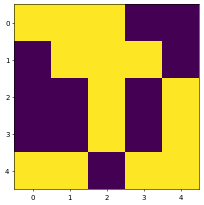

In [36]:
draw(ans[-1]['macro'])


Final Cantilever beam design:


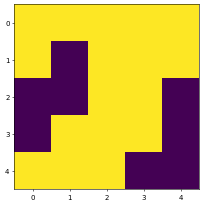

In [37]:
draw(ans[-1]['micro'])

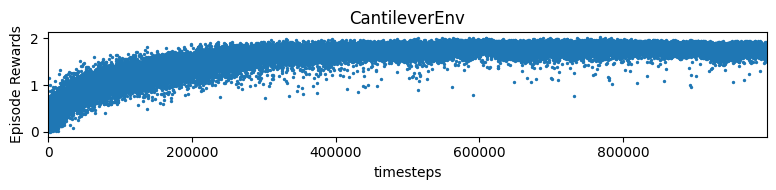

In [38]:
results_plotter.plot_results([log_dir], ts, results_plotter.X_TIMESTEPS, "CantileverEnv")

In [39]:
obs=env.reset()

In [40]:
obs=obs[0]

In [41]:
model_best = PPO.load(log_dir + "best_model.zip", env=env)

In [42]:
i=0
ans=[]
while i<1000:
    action, _states = model_best.predict(obs)
    obs, rewards, dones,_, info = env.step(action)
    ans.append(obs)
    if dones:
        break
    
    i+=1


Final Cantilever beam design:


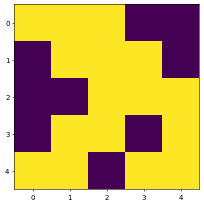

In [43]:
draw(ans[-1]['macro'])


Final Cantilever beam design:


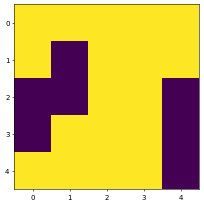

In [44]:
draw(ans[-1]['micro'])